In [1]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.sentiment.util import mark_negation
from datetime import datetime
import json
import re
from collections import defaultdict, Counter
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')

In [3]:
#define regular expressions and stop words   
url_regex = r'(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org)))\S*'
split_regex = r'[a-zA-Z_]+'
stop_words = set(stopwords.words('english'))

#function returns lower case tokens
def simple_tokenize(string):
    string = string.lower()
    return regexp_tokenize(string, split_regex)

#returns string without urls
def deURL(string):
    return re.sub(url_regex, '', string)
    
#removes stop words
def removeStopWords(tokenList):
    return [token for token in tokenList if token not in stop_words]


#cleans text (removes urls and stop words) and returns tokens
def cleanAndTokenize(text):
        noURLText = deURL(text)
        tokens = simple_tokenize(noURLText)
        tokens = mark_negation(tokens)
        return removeStopWords(tokens)


In [4]:
years = ['2015', '2016', '2017', '2018', '2019', '2020']
tweetDocs = dict()
wordCount = defaultdict(int)

for y in years:
    fileName = 'tweetData/' + y + 'rawTweetData.json'

    #open file with tweets for the year
    with open(fileName, 'r') as inFile:
        tweetData = json.load(inFile)

    inFile.close()

    for key, val in tweetData.items():
        tweetList = []
        newTokens = []
        for tweet in val:
            tweetList.append(tweet['full_text'])
            newTokens += cleanAndTokenize(tweet['full_text'])
  
        for token in newTokens:
            wordCount[token] += 1
            
        tweetDocs[key] = '. '.join(tweetList)

tweetDocs_df = pd.DataFrame.from_dict(tweetDocs, orient='index', columns=['AllTweets'])
tweetDocs_df.head()

,AllTweets
2015-01-01,"‡❋ 1/2 Half Pound lb Bitcoin Copper Bar ""Digit..."
2015-01-02,#Bitcoin #Litecoin #Dogecoin My reasons for re...
2015-01-03,New article! 3D Printing Company ISG Now Accep...
2015-01-04,Getting Geared up for some big #bitcoin news c...
2015-01-05,Marc Andreessen: I still stand behind bitcoin:...


In [5]:
vocabSet = set(key for key in wordCount if wordCount[key] > 3)

print('Unique Tokens:', len(vocabSet))

Unique Tokens: 33163


In [6]:
# create token-frequency inverse-document-frequence metrics for each day
tfidf_WordVectorizer = TfidfVectorizer(analyzer=cleanAndTokenize, vocabulary=vocabSet)

tweetDocs_tfidf = tfidf_WordVectorizer.fit_transform(tweetDocs_df.AllTweets)

tfidf_vals = pd.DataFrame(tfidf_WordVectorizer.idf_, tfidf_WordVectorizer.vocabulary, columns=['tf_idf'] )
tfidf_vals = tfidf_vals.sort_values(by = ['tf_idf'], ascending = False)

print('Top 10')
print(tfidf_vals.iloc[0:10])
print('')
print('Bottom 10')
print(tfidf_vals.iloc[:-11:-1])

Top 10
                 tf_idf
orangepillpod  8.693026
ordered        8.693026
concrete       8.693026
gtfo_NEG       8.693026
city_NEG       8.693026
qqq            8.693026
havent         8.693026
cheapest       8.693026
ownership      8.693026
touch          8.693026

Bottom 10
                 tf_idf
when_NEG       1.003655
inevitability  1.005029
alliancepay    1.005487
lib            1.005487
login_NEG      1.005487
cannon         1.005946
hatred         1.005946
reddcoin_NEG   1.006404
borrow         1.006404
terrible_NEG   1.009162


In [7]:
tweet_vecs = tweetDocs_tfidf.toarray()
tweet_vecs.shape


(2192, 33163)

In [8]:

tweetDocs_df = tweetDocs_df.rename_axis('Date')
tweetDocs_df = tweetDocs_df.reset_index()
tweetDocs_df.head()

,Date,AllTweets
0,2015-01-01,"‡❋ 1/2 Half Pound lb Bitcoin Copper Bar ""Digit..."
1,2015-01-02,#Bitcoin #Litecoin #Dogecoin My reasons for re...
2,2015-01-03,New article! 3D Printing Company ISG Now Accep...
3,2015-01-04,Getting Geared up for some big #bitcoin news c...
4,2015-01-05,Marc Andreessen: I still stand behind bitcoin:...


In [9]:
path = 'kaggle/input/'
file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv'
full_path = path + file_name
bitcoinData = pd.read_csv(full_path)

# renaming columns of dataset
bitcoinData = bitcoinData.rename(columns = {
    'Volume_(BTC)':'VolumeBTC',
    'Volume_(Currency)':'VolumeCurrency',
    'Weighted_Price':'WeightedPrice'
})

# convert Timestamp to a date
bitcoinData['Timestamp'] = pd.to_datetime( bitcoinData['Timestamp'], unit = 's' )

# remove rows with null values from the dataframe
bitcoinData = bitcoinData.dropna(how='all', subset=['Open','High','Low','Close','WeightedPrice'])
print('Dataframe rows after dropping null values:', bitcoinData.shape[0])

bitcoinData['Date'] = bitcoinData['Timestamp'].apply(datetime.date)

dailyData = bitcoinData.groupby(['Date']).mean()
indexOpen = pd.DataFrame(bitcoinData.groupby(['Date'])['Timestamp'].min())
indexClose = pd.DataFrame(bitcoinData.groupby(['Date'])['Timestamp'].max())

indexOpen = pd.merge(indexOpen, bitcoinData[['Date','Timestamp','Open']], how='left', on=['Date','Timestamp']).drop(['Timestamp'], axis=1)
indexClose = pd.merge(indexClose, bitcoinData[['Date','Timestamp','Open']], how='left', on=['Date','Timestamp']).drop(['Timestamp'], axis=1)


dailyData = pd.merge(indexOpen, indexClose, how='inner', on=['Date'])
dailyData = dailyData.rename(columns={'Open_x':'Open', 'Open_y':'Close'})

dailyData = dailyData.set_index('Date')

def dailyWeightAvg(dayGroup, volCol, wPriceCol):
    vol = dayGroup[volCol]
    price = dayGroup[wPriceCol]
    
    return ((vol * price).sum())/(vol.sum())

dailyData['High'] = bitcoinData.groupby(['Date'])['High'].max()
dailyData['Low'] = bitcoinData.groupby(['Date'])['Low'].min()
dailyData['VolumeBTC'] = bitcoinData.groupby(['Date'])['VolumeBTC'].sum()
dailyData['VolumeCurrency'] = bitcoinData.groupby(['Date'])['VolumeCurrency'].sum()
dailyData['WeightedDailyAvg'] = bitcoinData.groupby(['Date']).apply(dailyWeightAvg, 'VolumeBTC', 'WeightedPrice')

#calculate percent change for each day
dailyData['PercentChange'] = (((dailyData['WeightedDailyAvg']/dailyData['WeightedDailyAvg'].shift(periods=1))-1)*100)

#calculating rolling averages
dailyData['5DayAvg'] = ((dailyData.WeightedDailyAvg*dailyData.VolumeBTC+
                        dailyData.WeightedDailyAvg.shift(periods=1)*dailyData.VolumeBTC.shift(periods=1)+
                        dailyData.WeightedDailyAvg.shift(periods=2)*dailyData.VolumeBTC.shift(periods=2)+
                        dailyData.WeightedDailyAvg.shift(periods=3)*dailyData.VolumeBTC.shift(periods=3)+
                        dailyData.WeightedDailyAvg.shift(periods=4)*dailyData.VolumeBTC.shift(periods=4))/
                        (dailyData.VolumeBTC+
                         dailyData.VolumeBTC.shift(periods=1)+
                         dailyData.VolumeBTC.shift(periods=2)+
                         dailyData.VolumeBTC.shift(periods=3)+
                         dailyData.VolumeBTC.shift(periods=4)))

dailyData['10DayAvg'] = ((dailyData.WeightedDailyAvg*dailyData.VolumeBTC+
                        dailyData.WeightedDailyAvg.shift(periods=1)*dailyData.VolumeBTC.shift(periods=1)+
                        dailyData.WeightedDailyAvg.shift(periods=2)*dailyData.VolumeBTC.shift(periods=2)+
                        dailyData.WeightedDailyAvg.shift(periods=3)*dailyData.VolumeBTC.shift(periods=3)+
                        dailyData.WeightedDailyAvg.shift(periods=4)*dailyData.VolumeBTC.shift(periods=4)+
                        dailyData.WeightedDailyAvg.shift(periods=5)*dailyData.VolumeBTC.shift(periods=5)+
                        dailyData.WeightedDailyAvg.shift(periods=6)*dailyData.VolumeBTC.shift(periods=6)+
                        dailyData.WeightedDailyAvg.shift(periods=7)*dailyData.VolumeBTC.shift(periods=7)+
                        dailyData.WeightedDailyAvg.shift(periods=8)*dailyData.VolumeBTC.shift(periods=8)+
                        dailyData.WeightedDailyAvg.shift(periods=9)*dailyData.VolumeBTC.shift(periods=9))/
                        (dailyData.VolumeBTC+
                         dailyData.VolumeBTC.shift(periods=1)+
                         dailyData.VolumeBTC.shift(periods=2)+
                         dailyData.VolumeBTC.shift(periods=3)+
                         dailyData.VolumeBTC.shift(periods=4)+
                         dailyData.VolumeBTC.shift(periods=5)+
                         dailyData.VolumeBTC.shift(periods=6)+
                         dailyData.VolumeBTC.shift(periods=7)+
                         dailyData.VolumeBTC.shift(periods=8)+
                         dailyData.VolumeBTC.shift(periods=9)))

dailyData['20DayAvg'] = ((dailyData.WeightedDailyAvg*dailyData.VolumeBTC+
                        dailyData.WeightedDailyAvg.shift(periods=1)*dailyData.VolumeBTC.shift(periods=1)+
                        dailyData.WeightedDailyAvg.shift(periods=2)*dailyData.VolumeBTC.shift(periods=2)+
                        dailyData.WeightedDailyAvg.shift(periods=3)*dailyData.VolumeBTC.shift(periods=3)+
                        dailyData.WeightedDailyAvg.shift(periods=4)*dailyData.VolumeBTC.shift(periods=4)+
                        dailyData.WeightedDailyAvg.shift(periods=5)*dailyData.VolumeBTC.shift(periods=5)+
                        dailyData.WeightedDailyAvg.shift(periods=6)*dailyData.VolumeBTC.shift(periods=6)+
                        dailyData.WeightedDailyAvg.shift(periods=7)*dailyData.VolumeBTC.shift(periods=7)+
                        dailyData.WeightedDailyAvg.shift(periods=8)*dailyData.VolumeBTC.shift(periods=8)+
                        dailyData.WeightedDailyAvg.shift(periods=9)*dailyData.VolumeBTC.shift(periods=9)+
                        dailyData.WeightedDailyAvg.shift(periods=10)*dailyData.VolumeBTC.shift(periods=10)+
                        dailyData.WeightedDailyAvg.shift(periods=11)*dailyData.VolumeBTC.shift(periods=11)+
                        dailyData.WeightedDailyAvg.shift(periods=12)*dailyData.VolumeBTC.shift(periods=12)+
                        dailyData.WeightedDailyAvg.shift(periods=13)*dailyData.VolumeBTC.shift(periods=13)+
                        dailyData.WeightedDailyAvg.shift(periods=14)*dailyData.VolumeBTC.shift(periods=14)+
                        dailyData.WeightedDailyAvg.shift(periods=15)*dailyData.VolumeBTC.shift(periods=15)+
                        dailyData.WeightedDailyAvg.shift(periods=16)*dailyData.VolumeBTC.shift(periods=16)+
                        dailyData.WeightedDailyAvg.shift(periods=17)*dailyData.VolumeBTC.shift(periods=17)+
                        dailyData.WeightedDailyAvg.shift(periods=18)*dailyData.VolumeBTC.shift(periods=18)+
                        dailyData.WeightedDailyAvg.shift(periods=19)*dailyData.VolumeBTC.shift(periods=19))/
                        (dailyData.VolumeBTC+
                         dailyData.VolumeBTC.shift(periods=1)+
                         dailyData.VolumeBTC.shift(periods=2)+
                         dailyData.VolumeBTC.shift(periods=3)+
                         dailyData.VolumeBTC.shift(periods=4)+
                         dailyData.VolumeBTC.shift(periods=5)+
                         dailyData.VolumeBTC.shift(periods=6)+
                         dailyData.VolumeBTC.shift(periods=7)+
                         dailyData.VolumeBTC.shift(periods=8)+
                         dailyData.VolumeBTC.shift(periods=9)+
                         dailyData.VolumeBTC.shift(periods=10)+
                         dailyData.VolumeBTC.shift(periods=11)+
                         dailyData.VolumeBTC.shift(periods=12)+
                         dailyData.VolumeBTC.shift(periods=13)+
                         dailyData.VolumeBTC.shift(periods=14)+
                         dailyData.VolumeBTC.shift(periods=15)+
                         dailyData.VolumeBTC.shift(periods=16)+
                         dailyData.VolumeBTC.shift(periods=17)+
                         dailyData.VolumeBTC.shift(periods=18)+
                         dailyData.VolumeBTC.shift(periods=19)))

dailyData = dailyData.reset_index()

dailyData.head()

Dataframe rows after dropping null values: 3484305


,Date,Open,Close,High,Low,VolumeBTC,VolumeCurrency,WeightedDailyAvg,PercentChange,5DayAvg,10DayAvg,20DayAvg
0,2011-12-31,4.39,4.58,4.58,4.39,95.317878,425.320338,4.462126,NaN,NaN,NaN,NaN
1,2012-01-01,4.58,5.00,5.00,4.58,21.602000,105.779160,4.896730,9.739851,NaN,NaN,NaN
2,2012-01-02,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000,2.108960,NaN,NaN,NaN
3,2012-01-03,5.32,5.29,5.32,5.14,88.037281,464.805210,5.279641,5.592814,NaN,NaN,NaN
4,2012-01-04,4.93,5.37,5.57,4.93,107.233260,568.076197,5.297575,0.339681,5.009144,NaN,NaN


In [11]:
tweetDocs_df['Date'] = pd.to_datetime(tweetDocs_df['Date'], format='%Y-%m-%d')
dailyData['Date'] = pd.to_datetime(dailyData['Date'], format='%Y-%m-%d')

# Merge price data and Tweet Data
joinedData = pd.merge(tweetDocs_df, dailyData, on='Date')

joinedData.head(10)

,Date,AllTweets,Open,Close,High,Low,VolumeBTC,VolumeCurrency,WeightedDailyAvg,PercentChange,5DayAvg,10DayAvg,20DayAvg
0,2015-01-01,"‡❋ 1/2 Half Pound lb Bitcoin Copper Bar ""Digit...",321.00,313.81,321.00,312.60,3087.436554,9.745096e+05,315.637119,-0.085645,314.458390,320.208890,324.904799
1,2015-01-02,#Bitcoin #Litecoin #Dogecoin My reasons for re...,313.82,315.42,317.01,311.96,3468.281375,1.092446e+06,314.981849,-0.207602,314.413262,318.089324,324.205480
2,2015-01-03,New article! 3D Printing Company ISG Now Accep...,315.42,282.98,316.58,280.00,21752.719146,6.475952e+06,297.707695,-5.484175,306.037529,311.190968,320.415594
3,2015-01-04,Getting Geared up for some big #bitcoin news c...,280.00,264.00,289.39,255.00,41441.278553,1.126676e+07,271.872950,-8.677890,286.667806,296.232537,310.877959
4,2015-01-05,Marc Andreessen: I still stand behind bitcoin:...,264.55,276.80,280.00,264.07,9528.271002,2.596898e+06,272.546601,0.247782,282.632905,292.603585,307.143761
5,2015-01-09,#Ebay’s #Paypal embraces virtual currency #bit...,272.45,293.97,305.00,272.45,9914.249594,2.898085e+06,292.315153,7.253274,282.564312,290.674642,304.784026
6,2015-01-10,*-Top Informativo-* - How to Marry Buyer Perso...,293.89,275.59,295.00,271.03,29448.777845,8.367179e+06,284.126537,-2.801297,281.971660,288.586781,301.193400
7,2015-01-11,Poll Result: Most likely politician to support...,275.60,266.22,280.94,262.08,12758.949044,3.480737e+06,272.807499,-3.983802,277.517108,285.984759,298.663654
8,2015-01-12,#Bitcoin #Price Prediction Chart - #Bitcoins B...,266.34,267.14,272.43,263.54,10478.250214,2.823903e+06,269.501401,-1.211880,279.595489,283.226112,295.911683
9,2015-01-13,We are implementing new GloblalBoost-Y block e...,267.10,226.00,268.15,216.00,60556.162717,1.428937e+07,235.968829,-12.442448,258.689555,268.066325,281.953773


In [12]:
#For some reason there are 3 dates missing from the bitcoin data. So we will modify the dataframe
# to start at 2015-01-08 so that the data is continous day to day. This also means dropping the first
# 8 vectors from tweet_vecs
pd.date_range(start = '2015-01-01', end = '2020-12-31' ).difference(joinedData.Date)

DatetimeIndex(['2015-01-06', '2015-01-07', '2015-01-08'], dtype='datetime64[ns]', freq=None)

In [13]:
# drop dates so the dataset doesn't have discontinuous data
joinedData = joinedData.drop([0,1,2,3,4])
print(joinedData.shape)
print(tweet_vecs.shape)

(2184, 13)
(2192, 33163)


In [14]:
modified_tweet_vecs = tweet_vecs[8:-1]
print(joinedData.shape)
print(modified_tweet_vecs.shape)


(2184, 13)
(2183, 33163)


In [15]:
# define scaler
scaler = MinMaxScaler()

#scale data
dataList = scaler.fit_transform(joinedData[
    ['Open','High','Low','Close','VolumeBTC','WeightedDailyAvg',
     'PercentChange','5DayAvg','10DayAvg','20DayAvg']].values)


testSize = 365

# Create training and validation sets
X_=[]
Y_=[]

for i in range(len(dataList)-1):
        X_.append(np.array(dataList[i]).flatten())
        Y_.append(dataList[i+1][6])

print(len(dataList))
print(len(modified_tweet_vecs))
print(len(X_))
    
testSize = 365

X_train = np.array(X_[:len(X_)-testSize])
X_test = np.array(X_[len(X_)-testSize:])
Y_train = np.array(Y_[:len(Y_)-testSize])
Y_test = np.array(Y_[len(Y_)-testSize:])
XwordVec_train = modified_tweet_vecs[:len(modified_tweet_vecs)-testSize]
XwordVec_test = modified_tweet_vecs[len(modified_tweet_vecs)-testSize:]

print(len(X_train))
print(len(XwordVec_train))

assert (len(X_train)==len(Y_train))
assert (len(X_test)==len(Y_test))
assert (len(X_train)==len(XwordVec_train))
assert (len(X_test)==len(XwordVec_test))

X_train.shape[1]
XwordVec_train.shape[1]

2184
2183
2183
1818
1818


33163

In [128]:
# create Dense NN to make percentage change predictions based on word vectors

dropoutRate = 0.5

'''inputA = keras.layers.Input(X_train.shape[1])'''
inputB = keras.layers.Input(XwordVec_train.shape[1])

'''
xA = keras.layers.Dense(units=32)(inputA)
xA = keras.layers.BatchNormalization()(xA)
xA = keras.layers.Activation('relu')(xA)
xA = keras.layers.Dropout(dropoutRate)(xA)
xA = keras.layers.Dense(units=32,)(xA)
xA = keras.layers.BatchNormalization()(xA)
xA = keras.layers.Activation('relu')(xA)
xA = keras.layers.Dropout(dropoutRate)(xA)'''
                        
xB = keras.layers.Dense(units=2048)(inputB)
xB = keras.layers.BatchNormalization()(xB)
xB = keras.layers.Activation('relu')(xB)
xB = keras.layers.Dropout(dropoutRate)(xB)
xB = keras.layers.Dense(units=2048)(xB)
xB = keras.layers.BatchNormalization()(xB)
xB = keras.layers.Activation('relu')(xB)
xB = keras.layers.Dropout(dropoutRate)(xB)
xB = keras.layers.Dense(units=512)(xB)
xB = keras.layers.BatchNormalization()(xB)
xB = keras.layers.Activation('relu')(xB)
xB = keras.layers.Dropout(dropoutRate)(xB)
xB = keras.layers.Dense(units=128)(xB)
xB = keras.layers.BatchNormalization()(xB)
xB = keras.layers.Activation('relu')(xB)
xB = keras.layers.Dropout(dropoutRate)(xB)
outputB = keras.layers.Dense(1)(xB)


'''
conc = keras.layers.concatenate([xA, xB])

xC = keras.layers.Dense(units=128, activation='relu')(conc)
xB = keras.layers.BatchNormalization()(xB)
xB = keras.layers.Activation('relu')(xB)
xB = keras.layers.Dropout(dropoutRate)(xB)
xC = keras.layers.Dense(units=128, activation='relu')(xC)
'''

tweetModel = keras.Model(inputs=inputB, outputs=outputB)
tweetModel.compile(optimizer='adam', loss='mean_squared_error')
tweetModel.summary()

Model: "functional_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 33163)]           0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              67919872  
_________________________________________________________________
batch_normalization_8 (Batch (None, 2048)              8192      
_________________________________________________________________
activation_8 (Activation)    (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_9 (Batch (None, 2048)             

In [129]:
saveModel = keras.callbacks.ModelCheckpoint(filepath ='./tweetModel', monitor='val_loss', mode='min', save_best_only=True)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

#train Model
tweetModel.fit(XwordVec_train, Y_train, epochs=300,

               validation_data=(XwordVec_test, Y_test), callbacks=[saveModel, earlyStopping])

Epoch 1/300
57/57 [==============================] - ETA: 0s - loss: 1.2091WARNING:tensorflow:From C:\Users\hoove\anaconda3\envs\DL_Project\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\tweetModel\assets
57/57 [==============================] - 16s 281ms/step - loss: 1.2091 - val_loss: 0.1015
Epoch 2/300
57/57 [==============================] - 16s 282ms/step - loss: 0.7044 - val_loss: 0.0564
Epoch 3/300
57/57 [==============================] - 16s 285ms/step - loss: 0.4041 - val_loss: 0.0304
Epoch 4/300
57/57 [==============================] - 16s 283ms/step - loss: 0.2798 -

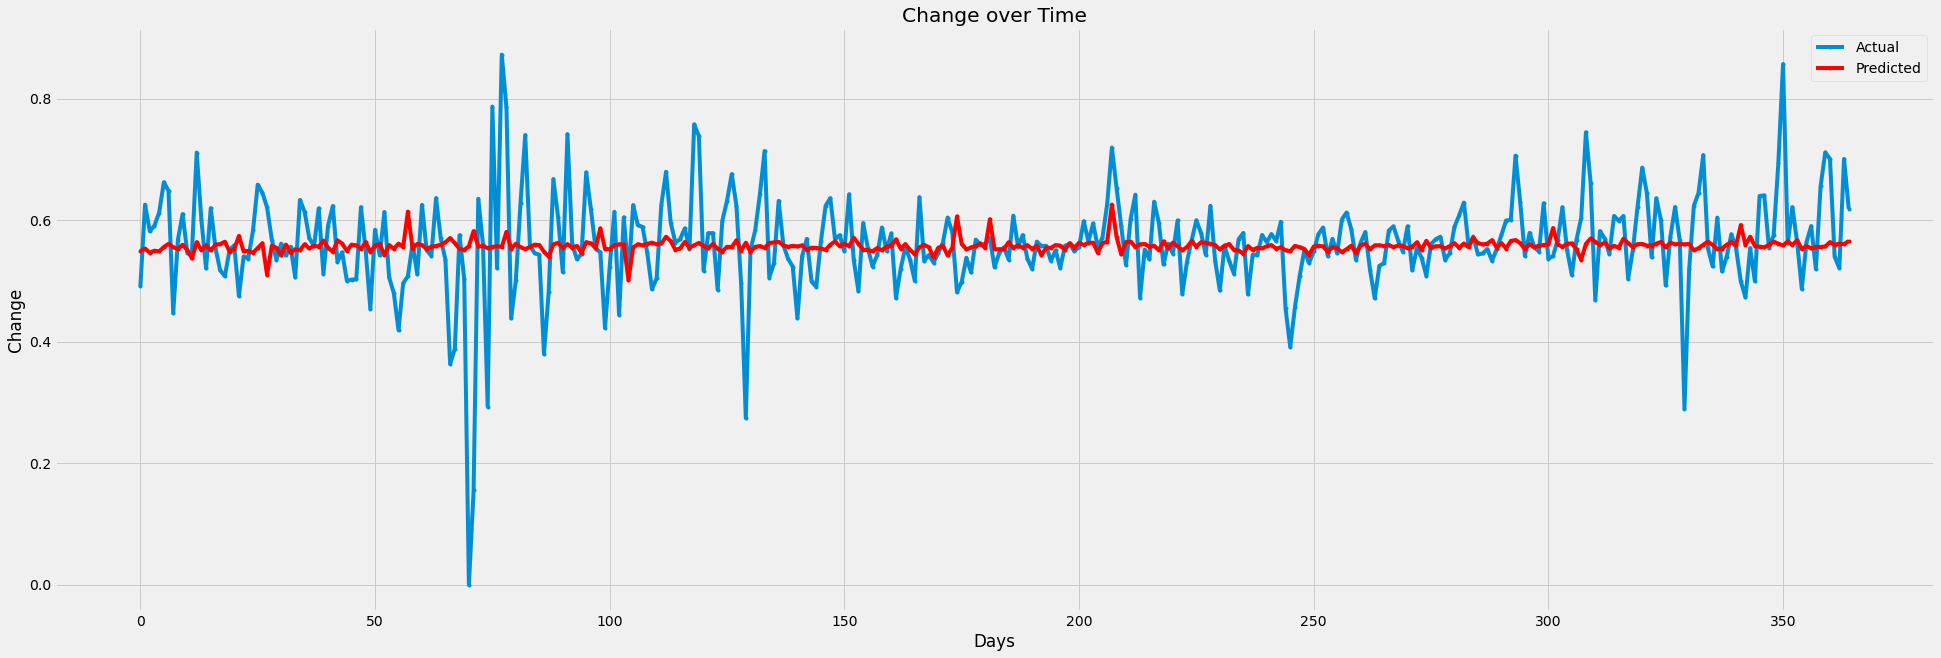

In [17]:
# Load best model
tweetModelPred = keras.models.load_model('./tweetModel')

# have model predict on validation set
preds = tweetModelPred.predict(XwordVec_test)
preds = [x[0] for x in preds]

#plot results
plt.figure(figsize=(30,10))
plt.plot(Y_test, marker='.', label="Actual")
plt.plot(preds, 'r', marker='.', label="Predicted")
plt.title('Change over Time')
plt.xlabel('Days')
plt.ylabel('Change')
plt.legend()